# Generate requirement.txt File

Uncomment this command to generate the requirement.txt file.

In [1]:
!pip3 freeze > ./requirements.txt

# Install Required Libraries

Uncomment this command to install all required libraries.

In [1]:
!pip3 install -r "./requirements.txt"

# Install Pre-Trained spaCy Models

In [ ]:
## If you want to run transformers model locally, uncomment the following line.
!python3 -m spacy download en_core_web_trf

## Uncomment this line if you dont have spacy model installed.
!python3 -m spacy download en_core_web_lg

# Forbes Articles Crawling

For data, articles on various topics (such as:
[Money](https://www.forbes.com/money/),
[Leadership](https://www.forbes.com/leadership/),
[Worlds-Billionaires](https://www.forbes.com/worlds-billionaires/),
[Business](https://www.forbes.com/business/),
[Small Business](https://www.forbes.com/small-business/),
[Life Style](https://www.forbes.com/lifestyle/),
[Real State](https://www.forbes.com/real-estate/) and etc
)
are extracted from the pages of
[Forbes](www.forbes.com) website.

> [Forbes](https://en.wikipedia.org/wiki/Forbes) is an American business magazine owned by Integrated Whale Media Investments and the Forbes family. Published eight times a year, it features articles on finance, industry, investing, and marketing topics. Forbes also reports on related subjects such as technology, communications, science, politics, and law.

**Scrapy** library in python was used to extract articles. The information extracted corresponding to each
article is as follows:

| Attribute                 | Description                                   | Type         |
| ------------------------- | --------------------------------------------- | ------------ |
| context_header            | category (context) of article                 | String       |
| corpus_date_ymd           | date of article publication (y/m/d)           | String       |
| corpus_date_hm            | date of release (h/m)                         | String       |
| corpus_title              | title of article                              | String       |
| corpus_content_paragraphs | paragraphs of article content                 | List(String) |
| author_var_dict           | profile of article author (described bellow.) | Dictionary   |

So that <code>author_var_dict</code> attribute contains the following fields:

| Attribute                | Description                      | Type         |
| ------------------------ | -------------------------------- | ------------ |
| author_forbes_url        | forbes url of article author     | String       |
| author_name              | article author name              | String       |
| author_contrib_type      | article author contributer type  | String       |
| author_subcontext_header | author field                     | String       |
| author_about             | a paragraph about article author | String       |
| author_social_links      | article author social links      | List(String) |

**Scrapy** library is installed with the following command:

<code>pip3 install scrapy</code>

(do not need to run this command if libraries are installed from requirement.txt file.)

and the current articles on the Forbes site are extracted in <code>file_name.json</code> using the following command:

<code>scrapy crawl forbes -O file_name.json</code>

The script for crawling forbes articles is in <code>ScrapyProject</code> folder and configurations is in <code>scrapy.cfg</code> file.:


# spaCy Library

In this project, **spaCy** library is used instead of **nltk**.

> A core difference between NLTK and spaCy stems from the way in which these libraries were built. NLTK is essentially a string processing library, where each function takes strings as input and returns a processed string. Though this seems like a simple way to use the library, in practice, you’ll often find yourself going back to the documentation to discover new functions. In contrast, spaCy takes an object-oriented approach. Each function returns objects instead of strings or arrays. This allows for easy exploration of the tool. Developers don’t need to constantly check with documentation to understand context because the object itself provides it. Each library utilizes either time or space to improve performance. While NLTK returns results much slower than spaCy (spaCy is a memory hog!), spaCy’s performance is attributed to the fact that it was written in Cython from the ground up.Most sources on the Internet mention that spaCy only supports the English language, but these articles were written a few years ago. Since then, spaCy has grown to support over 50 languages. Both spaCy and NLTK support English, German, French, Spanish, Portuguese, Italian, Dutch, and Greek.

# Import Libraries

In [3]:
import json

import numpy as np
import pandas as pd

import spacy
from spacy import displacy
from spacy.matcher import Matcher

from collections import Counter
from itertools import chain


2022-04-13 13:26:28.022152: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-13 13:26:28.022172: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Aggregate Json Files Data

In this section, <code>f{i}.json</code> format json files are aggregated and repeated items are removed.

In [4]:
n = 3
data = []
for i in range(n):
    file_i = open(f'f{i + 1}.json')
    dataset_i = json.load(file_i)
    data.extend(dataset_i)

titles = []
data_unique = []
for item in data:
    title = item['corpus_title']
    if title not in titles and 'author_var_dict' in item.keys():
        titles.append(title)
        data_unique.append(item)

data = data_unique

len(data)


193

# Dictionary to Dataframe

In [5]:
df = pd.json_normalize(data)
df = df

In [6]:
df["corpus_content_parts"] = df["corpus_content_parts"].\
    apply(lambda x: list(filter(lambda item: item not in 
                                ["Share to Facebook", "Share to Twitter", "Share to Linkedin"], x)))

df["corpus_content"] = df['corpus_content_parts'].apply(lambda x: " ".join(x))


# Some Samples From Contexts
In this section some samples from contexts are extracted and displayed.

In [7]:
series = df["corpus_content"].apply(lambda x: x.replace("", ""))
samples = df.groupby("context_header").apply(lambda x: x.sample(n=1))["corpus_content"]

pd.DataFrame(samples)


,,corpus_content
context_header,,
Billionaires,148,E lon Musk has never been a big charitable don...
Business,180,MLB is introducing ads on uniforms and expandi...
Leadership,183,Rags to riches is a uniquely United States sto...
Lifestyle,155,These delicious food-driven memoirs from enter...
Money,7,"Long-term investors save for important goals, ..."
Real Estate,152,"Every month, there are thousands of searches i..."
Small Business,120,Bootstrapping your business means relying on y...


# Download And Setup Pre-Trained Model

To download and setup spacy pre-trained language model, uncomment the following command.

In [9]:
nlp = spacy.load("en_core_web_lg")

# Extract Specifications of Corpus (1)

In this section, some specifications such as: *Number of Sentences*, *Average Lengths Of Sentences*, *Number of All Tokens*, *Number of Punctuation Tokens*, *Number of Stopwords* of corpus are extracted.

In [10]:
def extract_basic_specefications_of(text):
    doc = nlp(text)

    # collect doc.sents generator
    sentences = list(doc.sents)

    # doc tokens
    tokens = doc[:]

    n_all_tokens = len(tokens)
    n_sentences = len(sentences)

    average_sentence_len = sum(len(sentence)
                               for sentence in sentences) / n_sentences

    n_puncs = sum(map(lambda token: token.is_punct, tokens))
    n_stopwords = sum(map(lambda token: token.is_stop, tokens))

    # print(f'{n_sentences: <5}{n_total_tokens: <5}{n_puncs: <5}{n_stopwords: <5}')
    return n_sentences, average_sentence_len, n_all_tokens, n_puncs, n_stopwords


df[['No Sentences',
    'Average Lengths Of Sentences',
    'No All Tokens',
    'No Punctuation Tokens',
    'No Stopwords']] = df.apply(lambda item: extract_basic_specefications_of(item['corpus_content']), axis=1, result_type='expand')


# Preprocessing (Normalization)

For preprocessing, the following functions are applied to the text of the given articles, respectively:
$$
\text{Input Text} \Rightarrow \text{Lemmatization} \Rightarrow \text{Filter Stopwords} \Rightarrow \text{Filter Punctuations} \Rightarrow \text{Output Tokens}
$$

In [11]:
def normalize_component(text: str):
    text = text.lower().strip()

    doc = nlp(text)

    dataframe = pd.DataFrame(doc, columns=['spacy_token'])

    # lemmatization
    dataframe['word_str'] = dataframe['spacy_token'].apply(
        lambda token: token.lemma_)

    # remove whitespaces
    dataframe['word_str'] = dataframe['word_str'].apply(
        lambda word: word.strip())

    # filter whitespaces
    dataframe = dataframe[dataframe['word_str'].apply(lambda word: word != "")]

    # filter stopwords
    dataframe = dataframe[dataframe['spacy_token'].apply(
        lambda token: not token.is_stop)]

    # filter punctuations
    dataframe = dataframe[dataframe['spacy_token'].apply(
        lambda token: not token.is_punct)]

    return dataframe['spacy_token'].tolist(), dataframe['word_str'].tolist()


df[['spacy_tokens',
    'normalized_words']] = df.apply(lambda item: normalize_component(item['corpus_content']), axis=1, result_type='expand')


# Extract Specification of Corpus (2)

In this section, some specifications such as: *Number of Words*, *Number of Unique Words*, *Average Words Length*, *Longest Word Length* of corpus are extracted.

In [12]:
def extract_other_specifications_of(words):
    n_unique_words = len(set(words))

    n_words = len(words)
    average_word_len = sum(len(word) for word in words) / n_words
    longest_word_len = max(len(word) for word in words)

    return n_words, n_unique_words, average_word_len, longest_word_len


df[['No Words',
    'No Unique Words',
    'Average Words Length',
    'Longest Word Length']] = df.apply(lambda item: extract_other_specifications_of(item['normalized_words']), axis=1, result_type='expand')


# Aggregate Statistics About Articles

In this section, the statistics obtained from the data are shown for a sample of 5 articles.

In [13]:
n = 5

df[['context_header',
    'corpus_title',
    'No Sentences',
    'Average Lengths Of Sentences',
    'No All Tokens',
    'No Punctuation Tokens',
    'No Stopwords',
    'No Words',
    'No Unique Words',
    'Average Words Length',
    'Longest Word Length',
    ]].sample(n)


,context_header,corpus_title,No Sentences,Average Lengths Of Sentences,No All Tokens,No Punctuation Tokens,No Stopwords,No Words,No Unique Words,Average Words Length,Longest Word Length
32,Lifestyle,2022 Ford Bronco: 5 Reasons Why You Want The 2...,39.0,25.846154,1008.0,151.0,368.0,485.0,259.0,5.441237,14.0
78,Billionaires,Checkout.com Founder Guillaume Pousaz Now Euro...,22.0,27.181818,598.0,61.0,191.0,332.0,220.0,5.876506,14.0
189,Leadership,A New Report Shows The Impact Of Pandemic Play...,53.0,23.905660,1267.0,197.0,481.0,573.0,315.0,6.336824,14.0
20,Real Estate,Will Your Rent Keep Skyrocketing? Not If This ...,87.0,23.149425,2014.0,300.0,771.0,934.0,557.0,5.626338,15.0
56,Business,Spotify Says It Paid $7 Billion In Royalties I...,35.0,22.685714,794.0,81.0,295.0,383.0,199.0,5.368146,12.0


# Extract *NOUNs, ADVs, ADJs and VERBs* of Each Article

In this section, for each article *Nouns*, *Adverbs*, *Adjectives* and *Verbs* are extracted from the article.

In [14]:
pos_list = [['NOUN', 'PROPN'], ['ADJ'], ['ADV'], ['VERB']]
column_list = list(map(lambda p: f'normalized_{p[0]}s', pos_list))

for pos, column_name in zip(pos_list, column_list):
    df[column_name] = df['spacy_tokens'].\
        apply(lambda tokens: list(filter(lambda token: token.pos_ in pos, tokens))).\
        apply(lambda tokens: list(map(lambda token: token.lemma_, tokens)))

df[['context_header', 'corpus_title'] + column_list].sample(n=5)


,context_header,corpus_title,normalized_NOUNs,normalized_ADJs,normalized_ADVs,normalized_VERBs
119,Small Business,Record-Setting Venture Capital Market Shows Si...,"[lockdown, march, partner, venture, capital, f...","[pandemic, concerned, overdue, strong, geopoli...","[instead, downward, finally, considerably, far...","[induce, start, spread, happen, push, trend, o..."
168,Lifestyle,How York’s Newest Hotel Captures The Essence O...,"[bar, doll, house, floorboard, coral, bed, tur...","[mini, vivid, ready, retro, welcome, new, late...","[locally, upwards, truly, extra, merrily, nearby]","[find, paint, spin, emblazon, pack, find, open..."
161,Lifestyle,Pontiel Jewelry: Repurposed Antique Art Glass...,"[houston, designer, shelley, weather, company,...","[pontiel, sustainable, rare, exquisite, antiqu...","[mainly, gracefully, consequently, variously, ...","[base, mark, earn, repurpose, strike, echo, se..."
74,Billionaires,Gibraltar Detains Sanctioned Russian Billionai...,"[authority, territory, gibraltar, yacht, billi...","[british, overseas, sanctioned, russian, frenc...","[reportedly, originally, immediately, reported...","[detain, own, detain, own, bring, block, dereg..."
183,Leadership,The Uniquely American Story Of Brian Garish: Q...,"[rag, rich, state, story, dream, beginning, ad...","[united, american, humble, garish, little, dif...","[uniquely, hard, hard, especially, differently...","[start, work, fight, make, embody, go, stock, ..."


***

# Frequency Analysis
### Extract Most Frequent *Words* of Each Article

In this section, for each article, most frequent words and their frequency are extracted from the article.

In [15]:
def extract_n_most_frequent_word(words: list, n=20):
    word_freq = Counter(words)
    common_words_and_frequency = word_freq.most_common(n)

    return common_words_and_frequency


df['Common Words and Frequencies'] = df['normalized_words'].map(extract_n_most_frequent_word)

df['Common Words and Frequencies']

0      [($, 25), (earning, 20), (million, 19), (analy...
1      [(russia, 9), (war, 7), (ukraine, 6), (world, ...
2      [(russian, 14), (sanction, 13), (russia, 6), (...
3      [(dao, 60), (hoenisch, 38), ($, 32), (ethereum...
4      [(loan, 28), (payment, 28), (student, 23), (re...
                             ...                        
188    [(woman, 26), (work, 17), (couple, 16), (famil...
189    [(child, 31), (play, 21), (pandemic, 13), (par...
190    [(estate, 17), (plan, 12), (financial, 9), (tr...
191    [(investment, 10), (pioneer, 9), (m, 9), (inde...
192    [(rise, 11), (april, 6), (average, 6), (stock,...
Name: Common Words and Frequencies, Length: 193, dtype: object

### Word Cloud Visualization

In this section, for each category of articles (`context_header` attribute of each article in dataframe), a word cloud is generated.

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

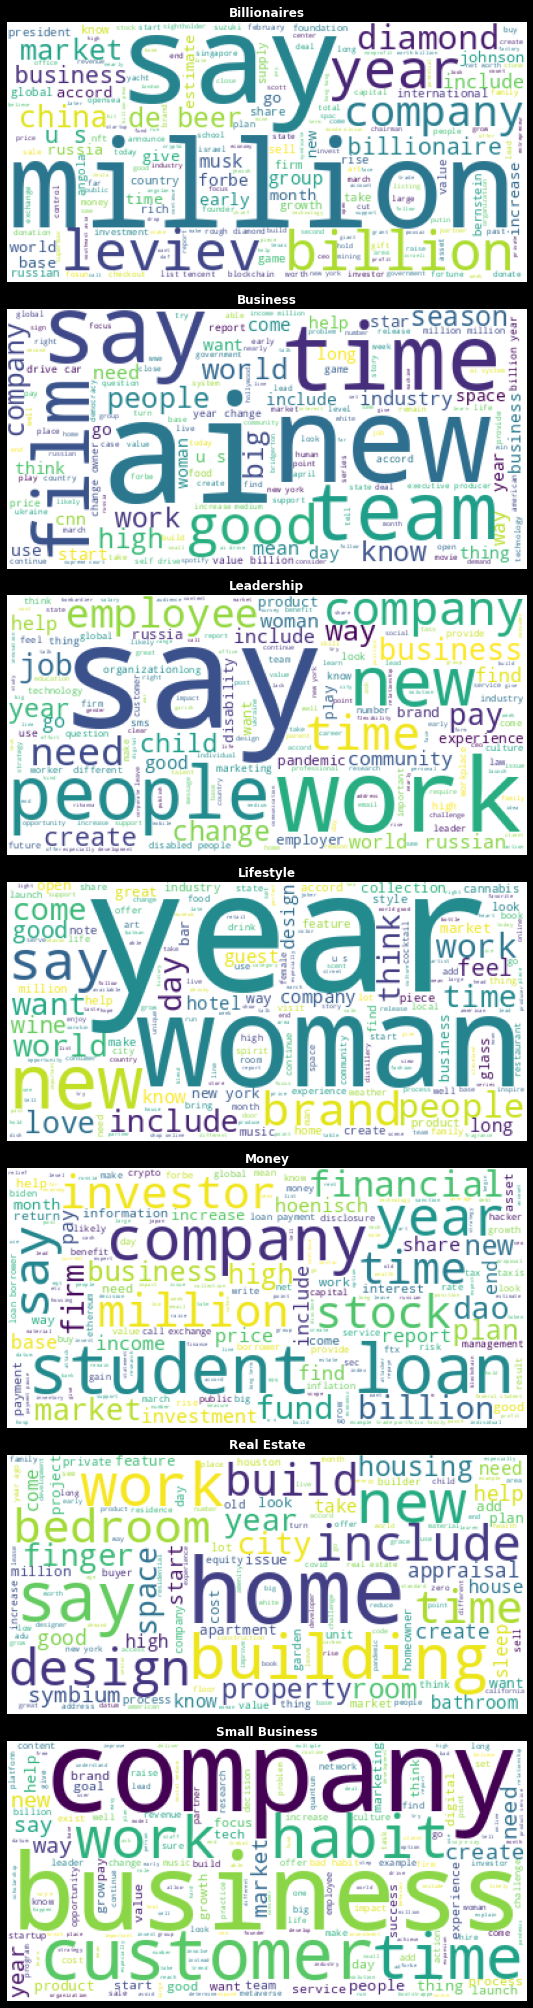

In [17]:
def plot_word_cloud(context: str, words: list, i_component, n_component, n=20):
    wc_bg_color = "white"
    spam_word_cloud = WordCloud(background_color=wc_bg_color,).generate(
        " ".join(words)
    )

    plt.subplot(n_component, 1, i_component)
    
    plt.imshow(spam_word_cloud)
    plt.title(context, fontweight="bold")
    plt.axis('off')



context_to_context_words = df.groupby("context_header").apply(
    lambda gp: list(chain.from_iterable(gp["normalized_words"].tolist()))
    ).to_dict()

n_component = len(context_to_context_words)
plt.figure(figsize=(8, 4 * n_component))
for i_component, (context, context_words) in enumerate(context_to_context_words.items()):
    plot_word_cloud(context, context_words, 
                    i_component + 1, n_component,
                    n=16)
    
plt.tight_layout()

### Extract Most Frequent *Words* of Each Context

In this section, most frequent words of each context (category) are extracted from the articles belong to that context.

In [18]:
groups_words = df.groupby("context_header").apply(
    lambda x: list(chain.from_iterable(x['normalized_words'].tolist()))
)

contexts_most_freq_words = groups_words.map(extract_n_most_frequent_word)

contexts_mf_words = pd.DataFrame(contexts_most_freq_words.to_dict())
contexts_mf_words


,Billionaires,Business,Leadership,Lifestyle,Money,Real Estate,Small Business
0,"($, 138)","(ai, 252)","(work, 126)","(year, 159)","(loan, 169)","(home, 103)","(business, 106)"
1,"(billion, 85)","($, 215)","(say, 123)","(new, 141)","($, 156)","(new, 52)","(company, 93)"
2,"(say, 82)","(million, 153)","(people, 120)","(say, 118)","(student, 136)","(say, 47)","(habit, 66)"
3,"(year, 82)","(year, 145)","(new, 68)","(woman, 118)","(company, 129)","(year, 41)","(customer, 63)"
4,"(leviev, 71)","(new, 106)","(company, 66)","(like, 104)","(year, 94)","(design, 39)","(say, 61)"
5,"(million, 70)","(say, 93)","(time, 66)","(good, 94)","(payment, 86)","(building, 39)","(time, 54)"
6,"(diamond, 60)","(time, 87)","(like, 59)","(world, 91)","(say, 76)","(work, 37)","(work, 47)"
7,"(company, 59)","(people, 81)","(employee, 58)","(brand, 85)","(price, 71)","(include, 35)","(create, 47)"
8,"(china, 36)","(like, 68)","(need, 56)","($, 70)","(income, 69)","(city, 33)","(new, 44)"
9,"(market, 34)","(drive, 65)","(business, 55)","(people, 70)","(million, 63)","(housing, 33)","(market, 44)"


### Extract Most Frequent *NOUN,ADV,ADJ,VERB* of Each Context

In this section, for each article in each context, most frequent *NOUN,ADV,ADJ,VERB* and their frequency are extracted from the articles belong to that context.
Because of the number of unique **pos** is not the same in different articles, the dataframe is displayed as a transpose.

In [19]:
def extract_n_most_frequent_word(words: list, n=10):
    word_freq = Counter(words)
    common_words_and_frequency = word_freq.most_common(n)
    return common_words_and_frequency


pos_to_mf = dict()
for pos, column_name in zip(pos_list, column_list):
    pos = pos[0]
    df[f'Common {pos}s and Frequencies'] = df[column_name].map(
        lambda words: extract_n_most_frequent_word(words, 5))

    groups_words = df.groupby("context_header").apply(
        lambda x: list(chain.from_iterable(x[column_name].tolist()))
    )

    contexts_most_freq_words = groups_words.map(
        lambda words: extract_n_most_frequent_word(words, 5))
    pos_to_mf[pos] = pd.DataFrame(contexts_most_freq_words.to_dict())


In [20]:
pos_to_mf['NOUN']


,Billionaires,Business,Leadership,Lifestyle,Money,Real Estate,Small Business
0,"(year, 82)","(year, 145)","(people, 120)","(year, 159)","(loan, 169)","(home, 99)","(business, 106)"
1,"(diamond, 60)","(time, 86)","(work, 71)","(woman, 118)","(student, 136)","(year, 41)","(company, 93)"
2,"(company, 59)","(people, 81)","(company, 66)","(world, 91)","(company, 128)","(building, 39)","(habit, 66)"
3,"(leviev, 48)","(ai, 73)","(time, 66)","(brand, 85)","(year, 94)","(city, 33)","(customer, 63)"
4,"(china, 36)","(film, 62)","(employee, 58)","(people, 70)","(payment, 86)","(bedroom, 32)","(time, 54)"


In [21]:
pos_to_mf['ADJ']


,Billionaires,Business,Leadership,Lifestyle,Money,Real Estate,Small Business
0,"(new, 28)","(new, 106)","(new, 68)","(new, 141)","(financial, 61)","(new, 52)","(new, 44)"
1,"(rough, 20)","(good, 55)","(disabled, 41)","(good, 88)","(high, 49)","(high, 22)","(bad, 32)"
2,"(early, 19)","(big, 49)","(good, 28)","(great, 47)","(federal, 40)","(real, 21)","(good, 25)"
3,"(rich, 19)","(high, 46)","(russian, 25)","(high, 39)","(new, 38)","(good, 21)","(digital, 20)"
4,"(large, 18)","(executive, 29)","(high, 23)","(female, 35)","(big, 30)","(low, 18)","(important, 16)"


In [22]:
pos_to_mf['ADV']


,Billionaires,Business,Leadership,Lifestyle,Money,Real Estate,Small Business
0,"(later, 14)","(fully, 18)","(long, 12)","(online, 32)","(far, 16)","(ago, 13)","(instead, 11)"
1,"(far, 12)","(nearly, 17)","(especially, 12)","(long, 30)","(later, 12)","(especially, 9)","(especially, 9)"
2,"(nearly, 8)","(far, 16)","(nearly, 12)","(well, 26)","(instead, 12)","(recently, 5)","(well, 8)"
3,"(ago, 7)","(long, 15)","(actually, 11)","(forward, 17)","(recently, 12)","(actually, 5)","(far, 7)"
4,"(early, 5)","(away, 14)","(early, 9)","(especially, 17)","(nearly, 11)","(currently, 5)","(consistently, 6)"


In [23]:
pos_to_mf['VERB']


,Billionaires,Business,Leadership,Lifestyle,Money,Real Estate,Small Business
0,"(say, 82)","(ai, 124)","(say, 123)","(say, 118)","(say, 76)","(say, 47)","(say, 61)"
1,"(include, 32)","(say, 93)","(work, 55)","(include, 66)","(find, 36)","(include, 35)","(create, 47)"
2,"(give, 24)","(drive, 65)","(create, 42)","(want, 63)","(base, 36)","(build, 28)","(work, 36)"
3,"(go, 20)","(know, 46)","(need, 40)","(come, 62)","(include, 35)","(create, 21)","(need, 31)"
4,"(accord, 19)","(come, 40)","(find, 36)","(think, 57)","(pay, 32)","(know, 20)","(help, 28)"


# Visualizing The Entity Recognizer

The entity visualizer, <code>ent</code>, highlights named entities and their labels in a text.

In [24]:
import random

random.seed(1)

sample_data = df.sample(n=1, random_state=1)
text = sample_data['corpus_content'].item()

doc = nlp(text)

sample_data = random.sample(list(doc.sents), 5)

options = {"compact": False}

displacy.render(sample_data, style="ent", minify=True, options=options)


/home/ahura/anaconda3/envs/DataEnvPIP/lib/python3.8/site-packages/spacy/displacy/__init__.py:189: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


# Visualizing The Dependency Parse Of Sample Text

The dependency visualizer, <code>dep</code>, shows part-of-speech tags and syntactic dependencies.

In [25]:
options = {"compact": False,
           "bg": "00FFFFFF",
           "color": "blue"}

displacy.render(sample_data, style="dep", minify=True, options=options)


# Chunking (POS Tagging + RegExp)

## Example on Sample Text from Data:

### Spacy Built-in Noun Chunks Extractor:

To get the noun chunks in a document, simply iterate over <code>Doc.noun_chunks</code>.

In [26]:
sample_data = df.sample(n=1, random_state=13)
text = sample_data['corpus_content'].item()
doc = nlp(text)


In [27]:
chunks = [chunk.text for chunk in doc.noun_chunks]
chunks


['Pony Ma',
 'the billionaire',
 'co',
 '-',
 'founder',
 'Chinese web giant Tencent',
 'his company',
 'sustainable long-term” growth',
 'Beijing’s crackdown',
 'its internet sphere',
 'Tencent’s market cap',
 'it',
 'The billionaire',
 'his Chinese name',
 'Ma Huateng',
 'the country’s internet industry',
 '“restructuring',
 'a healthy mode',
 'technological innovation',
 'social responsibility',
 'who',
 'China’s third-richest person',
 'a wealth',
 'the remarks',
 'his once-a-year address',
 'global media',
 'Tencent’s release',
 'fourth quarter',
 'annual results',
 'He',
 'continued progress',
 'areas',
 'international games',
 'an increase',
 'usage',
 'the so-called mini programs',
 'the WeChat instant messaging app',
 'We',
 'the new environment',
 'cost',
 'efficiency',
 'our focus',
 'key strategic areas',
 'ourselves',
 'sustainable long term growth',
 'he',
 'Tencent’s other senior management',
 'its billionaire President',
 'Martin Lau',
 'Ma’s remarks',
 'staunch support

### Custom Noun Chunks Extractor (Rule Based Pattern Matching):

Using **Part of Speech** tagging and **RegEx** pattern matching on pos of tokens, we can find noun-chunks in document.

The patterns, we use in this pattern matching issue are as follows:

| Key               | Example                                   | Pattern  |
| ----------------- | ----------------------------------------- | -------- |
| ORD_compositions  | pennsylvania real estate investment trust | pattern1 |
| OF_compositions   | core earnings of -$5.4                    | pattern2 |
| DASH_compositions | the robo-analyst finding                  | pattern3 |

(Pattern <code>pattern{i}</code> is defined in the following code snippet.)

In [28]:
matcher: Matcher = Matcher(nlp.vocab, validate=True)


def extract_noun_chunks(article_text, is_greedy=True, print_pos=False, min_n_component=3):

    article_text = article_text.lower()

    document = nlp(article_text)

    if print_pos:
        for token in document:
            print(token.text, token.tag_)

    DTs = ["DT", "PDT"]
    NNs = ["NN", "NNS", "NNP", "NNPS"]
    PRs = ["PfR", "PRP$"]  # Not PRP
    RBs = ["RB", "RBR", "RBS"]
    JJs = ["JJ", "JJR", "JJS"]

    NP = DTs + NNs + JJs + PRs + RBs

    pattern1 = [
        {"TAG": {"IN": NP}},
        {"TAG": {"IN": NP}, "OP": "+"},
    ]

    pattern2 = [
        {"TAG": {"IN": NP}, "OP": "+"},
        {"TEXT": {"IN": ["Of", "of"]}},
        {"TAG": {"IN": NP}, "OP": "+"},
    ]

    pattern3 = [
        {"TAG": {"IN": NP}, "OP": "+"},
        {"TEXT": "-"},
        {"TAG": {"IN": NP}, "OP": "+"},
    ]

    if is_greedy:
        matcher.add("ORD_compositions", [pattern1], greedy="LONGEST")
        matcher.add("OF_compositions", [pattern2], greedy="LONGEST")
        matcher.add("DASH_compositions", [pattern3], greedy="LONGEST")

    else:
        matcher.add("ORD_compositions", [pattern1], )
        matcher.add("OF_compositions", [pattern2], )
        matcher.add("DASH_compositions", [pattern3], )

    matches = [[nlp.vocab.strings[id_], document[start:end].text] for id_, start,
               end in matcher(document) if len(list(document[start:end])) >= min_n_component]

    matches = np.array(matches)

    return matches


print("Sample Data Context Header: " +
      sample_data['context_header'].item() + "\n")
print("Sample Data Title: " + sample_data['corpus_title'].item() + "\n")

print("Text: " + text[:25] + " ... \n")
print("-" * 50)

matches = extract_noun_chunks(text, print_pos=False, min_n_component=3)
_ = [print(x + " : " + y) for x, y in matches]


Sample Data Context Header: Billionaires

Sample Data Title: Billionaire Pony Ma Vows Long-Term Growth For Tencent Amid China Tech Crackdown

Text: Pony Ma, the billionaire  ... 

--------------------------------------------------
ORD_compositions : the same period a year ago
ORD_compositions : research firm blue lotus capital advisors
ORD_compositions : the billionaire co-founder
ORD_compositions : the wechat instant messaging app
ORD_compositions : full regulatory approval this january
ORD_compositions : our non-core businesses
ORD_compositions : chinese web giant tencent
ORD_compositions : sustainable long term growth
ORD_compositions : early 2021,the internet industry
ORD_compositions : its domestic games revenues
ORD_compositions : a thursday research note
ORD_compositions : market research firm omdia
ORD_compositions : finnish games developer supercell
ORD_compositions : the past several months
ORD_compositions : online advertising sales actually
ORD_compositions : a much smaller

## Noun Chunks on Whole Dataset Articles:

In [29]:
df["nominal_compositions"] = df['corpus_content'].apply(lambda text: extract_noun_chunks(text, min_n_component=3))

# Extract Most Important Noun Chunks

In this section, **chunks with less than three tokens** are filtered.

In this section, **chunks with less than three tokens** are filtered. In other words, our objective is to extract the most important chunks that have more than 3 tokens.

### TF-IDF vs Count Vectorizer

**TF-IDF is better than Count Vectorizers** because it not only focuses on the frequency of words present in the corpus but also provides the importance of the words. We can then remove the words that are less important for analysis, hence making the model building less complex by reducing the input dimensions.

![TF-IDF Image](./images/tfidf.png) 

### 1. TF-IDF Vectorization On Noun Chunks

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [31]:
tfidf = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)

column_index = 1
nominal_compositions_strings = [compositions[:, column_index].tolist() for compositions in df["nominal_compositions"]]

r = tfidf.fit_transform(nominal_compositions_strings)
response = r.toarray()
feature_array = np.array(tfidf.get_feature_names())

tfidf_df = pd.DataFrame(response, columns=feature_array)
df['key_phrases_tfidf'] = tfidf_df.apply(lambda row: (
    row.nlargest(5).index.tolist()), axis='columns')

df[['context_header', 'corpus_title', 'key_phrases_tfidf']]


/home/ahura/anaconda3/envs/DataEnvPIP/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,context_header,corpus_title,key_phrases_tfidf
0,Money,The Importance Of Reading Footnotes – Filing S...,"[the robo-analyst, % of gaap earnings, a total..."
1,Money,BlackRock CEO Larry Fink Says Russia-Ukraine W...,"[the cold war, the global economy, the world o..."
2,Money,U.S. Sanctions Over 400 Russian Elites And Ent...,"[the russian state duma, the russian governmen..."
3,Money,Exclusive: Austrian Programmer And Ex Crypto C...,"[the ethereum community, % of the eth, a grin ..."
4,Money,It's Your Last Chance To Get A Refund For Fede...,"[your student loans, federal student loans, st..."
...,...,...,...
188,Leadership,How Can Women Overcome The Challenges Of Greed...,"[the gender earnings gap, the greater economy,..."
189,Leadership,A New Report Shows The Impact Of Pandemic Play...,"[% of parents, % of those, % feeling increasin..."
190,Money,Estate Planning Made Easier,"[a financial advisor, a health care proxy, a l..."
191,Money,Is There A Perfect Portfolio?,"[the perfect portfolio, dimensional fund advis..."


### 2. TF-IDF Vectorization On Articles n-Grams

In this section, we simply calculate the TF-IDF vectors on the n-grams of each article and output the n-grams with the highest score as the most important chunks.

The lower and upper boundary of the range of n-values for different word n-grams or char n-grams to be extracted. All values of n such such that min_n <= n <= max_n will be used. For example an ngram_range of (1, 1) means only unigrams, (1, 2) means unigrams and bigrams, and (2, 2) means only bigrams. Only applies if analyzer is not callable.

In [32]:
tfidf = TfidfVectorizer(ngram_range=(3, 10))

r = tfidf.fit_transform(df['corpus_content'], )
response = r.toarray()
feature_array = np.array(tfidf.get_feature_names())
tfidf_df = pd.DataFrame(response, columns=feature_array)

df['key_phrases_ngrams'] = tfidf_df.apply(lambda row: (row.nlargest(5).index.tolist()), axis='columns')

df[['context_header', 'corpus_title', 'key_phrases_ngrams']]


/home/ahura/anaconda3/envs/DataEnvPIP/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,context_header,corpus_title,key_phrases_ngrams
0,Money,The Importance Of Reading Footnotes – Filing S...,"[the robo analyst, international flavors fragr..."
1,Money,BlackRock CEO Larry Fink Says Russia-Ukraine W...,"[been in place since, been in place since the,..."
2,Money,U.S. Sanctions Over 400 Russian Elites And Ent...,"[of the nation largest, russian state duma, th..."
3,Money,Exclusive: Austrian Programmer And Ex Crypto C...,"[in the dao, of the dao, the dao and, eth in t..."
4,Money,It's Your Last Chance To Get A Refund For Fede...,"[federal student loans, to get refund, your st..."
...,...,...,...
188,Leadership,How Can Women Overcome The Challenges Of Greed...,"[on call at, call at home, on call at home, ca..."
189,Leadership,A New Report Shows The Impact Of Pandemic Play...,"[during the pandemic, affected their child, af..."
190,Money,Estate Planning Made Easier,"[can help you, of your estate, able to manage,..."
191,Money,Is There A Perfect Portfolio?,"[fund advisors im, the perfect portfolio, theo..."


### 3. Yake Library 

In this section we use the **YAKE** library to extract key phrases.

**YAKE** is a light-weight unsupervised automatic keyword extraction method which rests on text statistical features extracted from single documents to select the most important keywords of a text. Our system does not need to be trained on a particular set of documents, neither it depends on dictionaries, external-corpus, size of the text, language or domain. To demonstrate the merits and the significance of our proposal, we compare it against ten state-of-the-art unsupervised approaches (TF.IDF, KP-Miner, RAKE, TextRank, SingleRank, ExpandRank, TopicRank, TopicalPageRank, PositionRank and MultipartiteRank), and one supervised method (KEA). Experimental results carried out on top of twenty datasets (see Benchmark section below) show that our methods significantly outperform state-of-the-art methods under a number of collections of different sizes, languages or domains. In addition to the python package here described, we also make available a demo, an API and a mobile app.

In [33]:
# Uncomment to install yake using pip
# !pip3 install git+https://github.com/LIAAD/yake

import yake

In [34]:
def extract_key_phrases_keywords(text: str, yake_keyword_extractor):
    keywords = yake_keyword_extractor.extract_keywords(text)
    return list(map(lambda kw: kw[0], keywords))


In [35]:
language = "en"
max_ngram_size = 3
deduplication_algorithme = 'seqm'
window_size = 1
n_keywords = 20

yake_keyword_extractor = yake.KeywordExtractor(
    lan=language,
    n=max_ngram_size,
    dedupFunc=deduplication_algorithme,
    windowsSize=window_size,
    top=n_keywords,
    features=None,
)

df["key_phrases_yake_extractor"] = df['corpus_content'].apply(lambda text: extract_key_phrases_keywords(text, yake_keyword_extractor))

df[['context_header', 'corpus_title', 'key_phrases_yake_extractor']]

,context_header,corpus_title,key_phrases_yake_extractor
0,Money,The Importance Of Reading Footnotes – Filing S...,"[GAAP earnings, Filing Season Finds, Earnings,..."
1,Money,BlackRock CEO Larry Fink Says Russia-Ukraine W...,"[Chairman Larry Fink, warned BlackRock CEO, Co..."
2,Money,U.S. Sanctions Over 400 Russian Elites And Ent...,"[Russian State Duma, White House, Russian Pres..."
3,Money,Exclusive: Austrian Programmer And Ex Crypto C...,"[DAO, Hoenisch, Ethereum, ILLUSTRATION BY PATR..."
4,Money,It's Your Last Chance To Get A Refund For Fede...,"[federal student loans, student loans, student..."
...,...,...,...
188,Leadership,How Can Women Overcome The Challenges Of Greed...,"[women, Henry Lee Professor, work, family, cou..."
189,Leadership,A New Report Shows The Impact Of Pandemic Play...,"[children, play, pandemic, parents, Toys, chil..."
190,Money,Estate Planning Made Easier,"[Managing Partner, Estate, Estate planning, Jo..."
191,Money,Is There A Perfect Portfolio?,"[Stephen Foerster, University of Western, West..."


# Classification Based On TF-IDF Features

In this section, we will examine the classification of the articles based on the TF-IDF features. (The TF-IDF features are extracted from the **article's words and n-grams** and labels are assigned to the articles based on **article context header**.)

### y Column Label Encoding

In this section. we encode unique string values of the y column to integers. 

In [36]:
from sklearn.preprocessing import LabelEncoder

label_column = 'context_header'

le = LabelEncoder()
le.fit(df[label_column])

le.classes_


array(['Billionaires', 'Business', 'Leadership', 'Lifestyle', 'Money',
       'Real Estate', 'Small Business'], dtype=object)

In [37]:
y_column = 'Y'
df[y_column] = le.transform(df[label_column])

df[y_column]

0      4
1      4
2      4
3      4
4      4
      ..
188    2
189    2
190    4
191    4
192    4
Name: Y, Length: 193, dtype: int64

In [38]:
le.inverse_transform(df[y_column])

array(['Money', 'Money', 'Money', 'Money', 'Money', 'Money', 'Money',
       'Money', 'Money', 'Leadership', 'Billionaires', 'Business',
       'Small Business', 'Lifestyle', 'Real Estate', 'Real Estate',
       'Real Estate', 'Real Estate', 'Money', 'Real Estate',
       'Real Estate', 'Real Estate', 'Real Estate', 'Lifestyle',
       'Lifestyle', 'Lifestyle', 'Lifestyle', 'Lifestyle', 'Lifestyle',
       'Lifestyle', 'Lifestyle', 'Lifestyle', 'Lifestyle', 'Lifestyle',
       'Lifestyle', 'Lifestyle', 'Lifestyle', 'Lifestyle', 'Lifestyle',
       'Lifestyle', 'Lifestyle', 'Lifestyle', 'Lifestyle', 'Lifestyle',
       'Lifestyle', 'Lifestyle', 'Lifestyle', 'Lifestyle',
       'Small Business', 'Small Business', 'Small Business',
       'Small Business', 'Small Business', 'Business', 'Business',
       'Business', 'Business', 'Business', 'Business', 'Business',
       'Business', 'Business', 'Business', 'Business', 'Business',
       'Business', 'Business', 'Business', 'Business', 'Busi

### Train-Test Split 

In [39]:
from sklearn.model_selection import train_test_split

test_size = 0.2
train_df, validation_df = train_test_split(df, test_size=test_size)

train_y = train_df[y_column]
train_df.drop([y_column], axis=1, inplace=True)

validation_y = validation_df[y_column]
validation_df.drop([y_column], axis=1, inplace=True)


### TF-IDF Feature Extraction {n-Grams(1, 5)}

In [40]:
vectorizer = TfidfVectorizer(ngram_range=(1, 5), token_pattern=r'\w{1,}')

train_X = vectorizer.fit_transform(train_df['corpus_content'])
validation_X = vectorizer.transform(validation_df['corpus_content'])

### Import Classifiers

In [41]:
from sklearn.linear_model import RidgeClassifier, SGDClassifier, PassiveAggressiveClassifier, Perceptron, LogisticRegression, LogisticRegressionCV
from sklearn.svm import LinearSVC, SVC, LinearSVR, SVR
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix


### Model Training And Evaluation

In [42]:
from time import time

def benchmark(clf, x_train, y_train, x_validation, y_validation,):
    print("_" * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(x_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(x_validation)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = accuracy_score(y_validation, pred)
    print("accuracy:   %0.3f" % score)

    print("classification report:")
    print(classification_report(y_validation, pred, target_names=le.classes_, zero_division=0))

    print("confusion matrix:")
    print(confusion_matrix(y_validation, pred))

    print()
    clf_descr = str(clf).split("(")[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
    (RidgeClassifier(tol=1e-2, solver="sag", max_iter=1000), "Ridge Classifier"),
    (Perceptron(max_iter=50), "Perceptron"),
    (PassiveAggressiveClassifier(max_iter=50), "Passive-Aggressive"),
    (KNeighborsClassifier(n_neighbors=10), "kNN"),
    (RandomForestClassifier(), "Random forest"),
    (LinearSVC(penalty="l2", dual=False, tol=1e-3), "Linear SVM"),
    (SGDClassifier(alpha=0.0001, max_iter=500, penalty="l2"), "SGD Classifier"),
    (MultinomialNB(alpha=0.01), "Multinomial Naive Bayes"),
    (BernoulliNB(alpha=0.01), "Bernoulli Naive Bayes"),    
    (ComplementNB(alpha=0.1), "Complement Naive Bayes"),
):
    print("=" * 80)
    print(name)
    result = benchmark(clf, train_X, train_y, validation_X, validation_y)
    results.append(result)
    

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(max_iter=1000, solver='sag', tol=0.01)
train time: 0.718s
test time:  0.049s
accuracy:   0.564
classification report:
                precision    recall  f1-score   support

  Billionaires       0.00      0.00      0.00         4
      Business       0.50      0.33      0.40         6
    Leadership       0.40      0.67      0.50         3
     Lifestyle       0.56      1.00      0.72        14
         Money       1.00      0.38      0.55         8
   Real Estate       0.00      0.00      0.00         3
Small Business       0.50      1.00      0.67         1

      accuracy                           0.56        39
     macro avg       0.42      0.48      0.40        39
  weighted avg       0.53      0.56      0.49        39

confusion matrix:
[[ 0  0  0  4  0  0  0]
 [ 0  2  0  4  0  0  0]
 [ 0  1  2  0  0  0  0]
 [ 0  0  0 14  0  0  0]
 [ 0  1  1  2  3  0  1]


As can be seen in the results, classifiers such as Perceptron, kNN and SGD Classifier **have reached accuracy of more than 50%.**

# 